# Transfer learning with tensor flow


Download data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2022-02-22 14:11:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   195MB/s    in 0.8s    

2022-02-22 14:11:02 (195 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

there are 2 directories and 0 images in "10_food_classes_10_percent".
there are 10 directories and 0 images in "10_food_classes_10_percent/train".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/pizza".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/fried_rice".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/grilled_salmon".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/hamburger".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/steak".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/sushi".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/chicken_wings".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/ramen".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/ice_cream".
there are 0 directories and 75 images in "10_food_classes_10_percent/train/c

## Preparing data


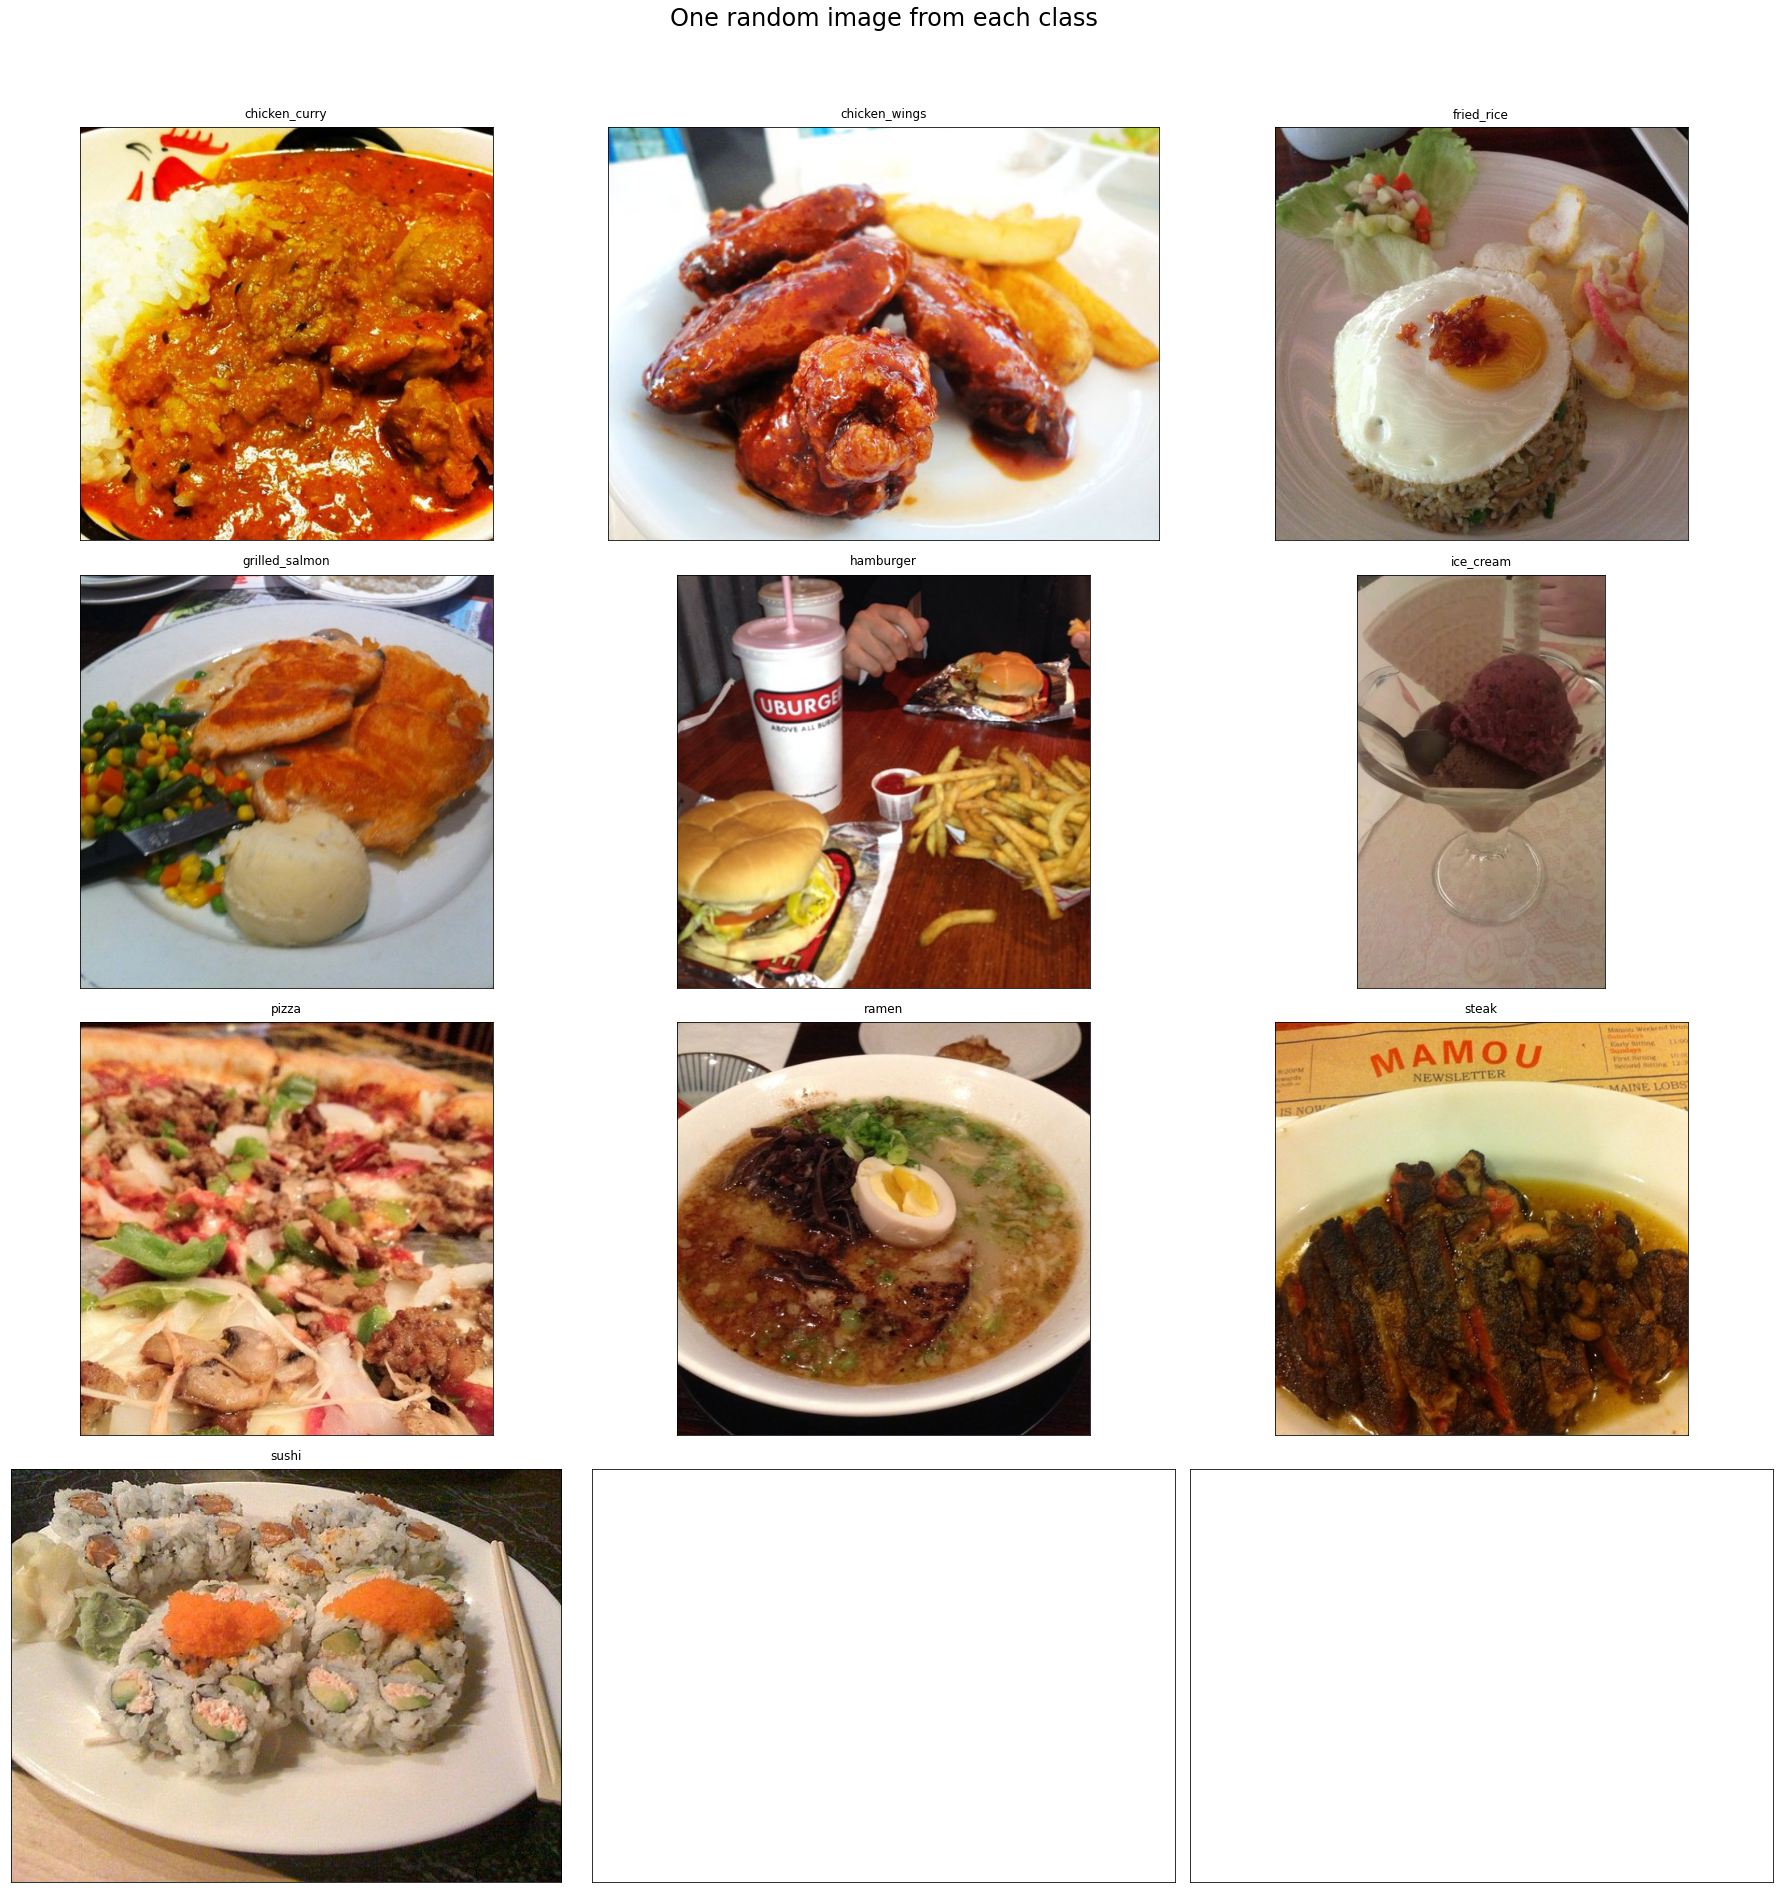

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rows = 4
cols = 3
fig, ax = plt.subplots(rows, cols, figsize=(25, 25))
fig.suptitle('One random image from each class', fontsize=24, y=1.05)

data_dir = '10_food_classes_10_percent/train'
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0

for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
      continue
    
    food_selected_images = os.listdir(os.path.join(data_dir, food_selected))

    food_selected_random = np.random.choice(food_selected_images)

    img = plt.imread(os.path.join(data_dir, food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad=10)

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
foods = ['chicken_curry','chicken_wings','fried_rice','grilled_salmon','hamburger','ice_cream', 'pizza', 'ramem', 'steak', 'sushi']

In [ ]:
import tensorflow as tf

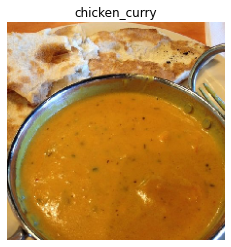

In [ ]:
images, labels = train_data.next()

plt.title(foods[np.argmax(labels[1])])
plt.imshow(images[1])
plt.axis(False);

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f'Saving tensorboard log files to: {log_dir}')
  return tensorboard_callback

## Using Pre-trained models


In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
                               feature_extractor_layer,
                               layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
resnet_model = create_model(resnet_url)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.SGD(),
                     metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])


Saving tensorboard log files to: tensorflow_hub/resnet50V2/20220222-141119
Epoch 1/5
24/24 [==============================] - 63s 2s/step - loss: 1.7862 - accuracy: 0.4027 - val_loss: 1.1659 - val_accuracy: 0.6508
Epoch 2/5
24/24 [==============================] - 30s 1s/step - loss: 1.0036 - accuracy: 0.7013 - val_loss: 0.9128 - val_accuracy: 0.7260
Epoch 3/5
24/24 [==============================] - 48s 2s/step - loss: 0.8060 - accuracy: 0.7440 - val_loss: 0.8004 - val_accuracy: 0.7660
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.6863 - accuracy: 0.7880 - val_loss: 0.7486 - val_accuracy: 0.7776
Epoch 5/5
24/24 [==============================] - 27s 1s/step - loss: 0.6012 - accuracy: 0.8080 - val_loss: 0.7091 - val_accuracy: 0.7840


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  #plot loss
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='test loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='test accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


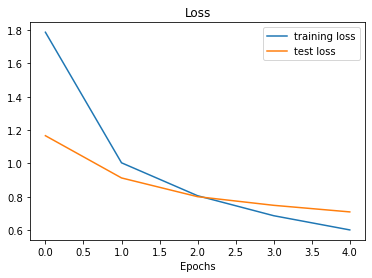

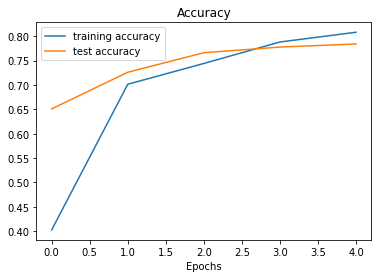

In [ ]:
plot_loss_accuracy(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
efficientnet_model = create_model(efficientnet_url)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetB0')])

Saving tensorboard log files to: tensorflow_hub/efficientnetB0/20220222-142037
Epoch 1/5
24/24 [==============================] - 33s 947ms/step - loss: 1.8348 - accuracy: 0.4533 - val_loss: 1.3099 - val_accuracy: 0.7576
Epoch 2/5
24/24 [==============================] - 21s 884ms/step - loss: 1.0485 - accuracy: 0.7880 - val_loss: 0.8639 - val_accuracy: 0.8392
Epoch 3/5
24/24 [==============================] - 21s 888ms/step - loss: 0.7451 - accuracy: 0.8360 - val_loss: 0.6948 - val_accuracy: 0.8572
Epoch 4/5
24/24 [==============================] - 20s 878ms/step - loss: 0.5989 - accuracy: 0.8773 - val_loss: 0.6053 - val_accuracy: 0.8624
Epoch 5/5
24/24 [==============================] - 21s 890ms/step - loss: 0.5066 - accuracy: 0.8920 - val_loss: 0.5504 - val_accuracy: 0.8724


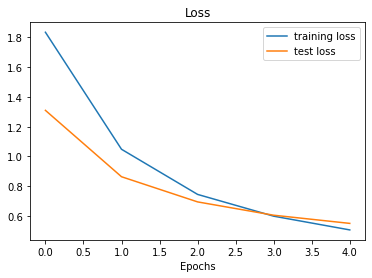

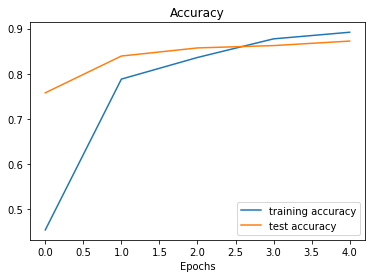

In [ ]:
plot_loss_accuracy(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Comparing experiments in tensorboard

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
 --name 'EfficientNetB0 vs ResNet50V2' \
 --description 'Comparing two different TF Hub feature extraction models architetures' \
 --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=BO4QfFVnOwlZw2vZsYtfWigGpzvhRu&prompt=consent&access_type=off

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/QR7FV1TvTVSEcxGv24U85w/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architetures
	Id                   QR7FV1TvTVSEcxGv24U85w
	Created              2022-02-22 14:30:04 (12 minutes ago)
	Updated              2022-02-22 14:30:07 (12 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  9989530
Total: 1 experiment(s)


In [ ]:
#!tensorboard dev delete --experiment_id QR7FV1TvTVSEcxGv24U85w

# Transfer learning: fine-tuning


In [ ]:
!nvidia-smi

Fri Mar  4 16:34:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-03-04 16:34:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-04 16:34:19 (73.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## 10 Food classes

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2022-03-04 16:34:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 74.125.201.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   191MB/s    in 0.8s    

2022-03-04 16:34:23 (191 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
train_dir = '10_food_classes_10_percent/train/'

test_dir = '10_food_classes_10_percent/test/'

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
classes = train_data_10_percent.class_names

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

x = base_model(inputs)
print(f'Shape after base_model: {x.shape}')

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'After GlobalAveragePooling2D(): {x.shape}')

outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

model_0 = tf.keras.Model(inputs,outputs)

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=len(test_data_10_percent),
                        callbacks=[create_tensorboard_callback('transfer_learning', '10_percent_feature_extract')])


16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220304-163439
Epoch 1/5
24/24 [==============================] - 38s 717ms/step - loss: 1.9414 - accuracy: 0.3907 - val_loss: 1.4016 - val_accuracy: 0.6808
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.1593 - accuracy: 0.7427 - val_loss: 0.9496 - val_accuracy: 0.7960
Epoch 3/5
24/24 [==============================] - 16s 639ms/step - loss: 0.8453 - accuracy: 0.8093 - val_loss: 0.7648 - val_accuracy: 0.8200
Epoch 4/5
24/24 [==============================] - 15s 638ms/step - loss: 0.7001 - accuracy: 0.8320 - val_loss: 0.6714 - val_accuracy: 0.8328
Epoch 5/5
24/24 [==============================] - 15s 617ms/step - loss: 0.5921 - accuracy: 0.8587 - val_loss: 0.6155 - val_accuracy: 0.8404


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


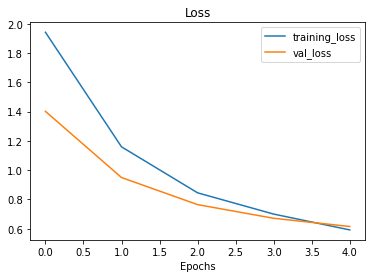

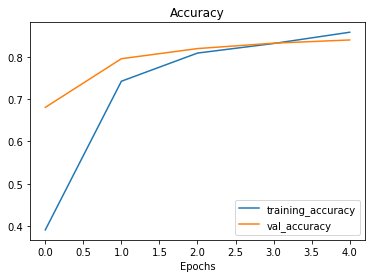

In [ ]:
plot_loss_curves(history_0)

In [ ]:
input_shape = (1, 4, 4, 3)

input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 1.6069788  -1.0377231   1.7132311 ]
   [-0.41821426  0.05953844  0.3030443 ]
   [ 2.141637   -0.42766753  1.3909258 ]
   [-1.5699387   0.6689463  -0.422231  ]]

  [[-0.7082065   0.7042856  -0.21853393]
   [-0.232954   -1.6587732   0.2810225 ]
   [ 0.6767421   1.9498183  -0.2213281 ]
   [-0.30293092  2.7387822   1.7640827 ]]

  [[ 0.4502445  -0.14884652  2.6494973 ]
   [ 0.56922275  1.1830488  -0.71754503]
   [-0.41453877  0.81308067 -0.8340649 ]
   [-1.4497335  -0.5177898   0.08301245]]

  [[-0.34060973  0.66252744  1.6234261 ]
   [ 0.16829084  0.95241106  1.8701005 ]
   [ 0.17587958 -2.0082088  -1.2958195 ]
   [ 1.5695785  -2.031341   -0.12876782]]]]

2D global average pooled random tensor:
 [[0.1200905  0.11888056 0.4900033 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.1200905 , 0.11888056, 0.4900033 ]], dtype=float32)>

### Feature extraction transfer learning on 1% of training data with data augmentation


**Model 1** - 1% of data and data augmentation

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

--2022-03-04 16:36:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   179MB/s    in 0.7s    

2022-03-04 16:36:49 (179 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescaling(1./2) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                 shear_range=0.2,
                                 zoom_range=0.2)

train_data_1_percent_aug = train_datagen.flow_from_directory(train_dir_1_percent,
                                                             target_size=IMG_SIZE,
                                                             batch_size=32,
                                                             class_mode='categorical')

Found 70 images belonging to 10 classes.


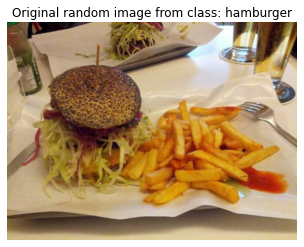

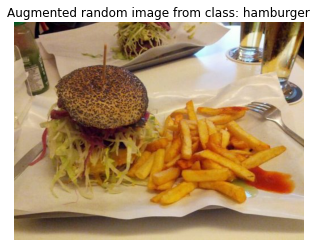

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25* len(test_data)),
                        callbacks=[create_tensorboard_callback('tranfer_learning', '1_percent_data_aug')])

Saving TensorBoard log files to: tranfer_learning/1_percent_data_aug/20220304-163655
Epoch 1/5
3/3 [==============================] - 18s 4s/step - loss: 2.3390 - accuracy: 0.1143 - val_loss: 2.2550 - val_accuracy: 0.1678
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.1276 - accuracy: 0.1857 - val_loss: 2.1506 - val_accuracy: 0.2237
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9733 - accuracy: 0.3857 - val_loss: 2.0382 - val_accuracy: 0.3010
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.7813 - accuracy: 0.5857 - val_loss: 1.9435 - val_accuracy: 0.3635
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.6236 - accuracy: 0.6571 - val_loss: 1.8490 - val_accuracy: 0.4293


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 13s 149ms/step - loss: 1.8519 - accuracy: 0.4116


[1.8519014120101929, 0.4115999937057495]

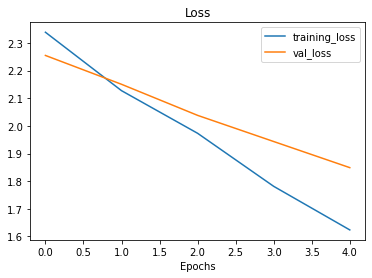

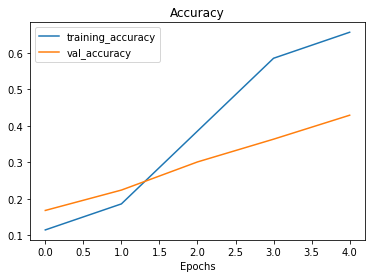

In [ ]:
plot_loss_curves(history_1)

**Model 2** - 10% of data and data augmentation

In [ ]:
train_dir_10_percent = '/content/10_food_classes_10_percent/test/'

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)


Found 2500 files belonging to 10 classes.


In [ ]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(0.001),
            metrics=['accuracy'])

Model checkpoint

In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

In [ ]:
initial_epochs = 5

history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), checkpoint_callback]
                        )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220304-163758
Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 1.4682 - accuracy: 0.5732
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 56s 547ms/step - loss: 1.4682 - accuracy: 0.5732 - val_loss: 0.7368 - val_accuracy: 0.8372
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.7976
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 40s 505ms/step - loss: 0.7643 - accuracy: 0.7976 - val_loss: 0.5219 - val_accuracy: 0.8717
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.8224
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
79/79 [==============================] - 41s 504ms/step - loss: 0.6172 - accuracy: 0.8224 - val_loss: 0.4379 - val_accuracy: 0.8766
E

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 12s 139ms/step - loss: 0.3709 - accuracy: 0.8928


[0.3708983063697815, 0.892799973487854]

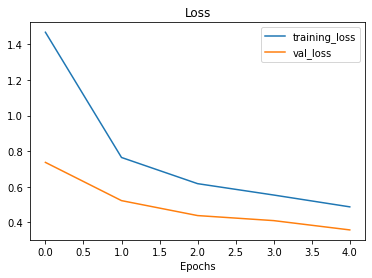

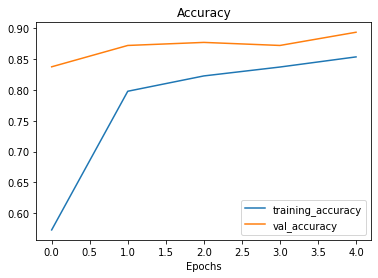

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.load_weights(checkpoint_path)
model_2.evaluate(test_data)

79/79 [==============================] - 13s 148ms/step - loss: 0.3709 - accuracy: 0.8928


[0.37089842557907104, 0.892799973487854]

**Model 3** - Fine-tuning model on 10% of data

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
base_model.trainable = True

#freeze all layers except for the top 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        initial_epoch=history_2.epoch[-1],
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately)

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220304-164314
Epoch 5/10
79/79 [==============================] - 47s 469ms/step - loss: 0.4386 - accuracy: 0.8596 - val_loss: 0.3089 - val_accuracy: 0.8964
Epoch 6/10
79/79 [==============================] - 33s 410ms/step - loss: 0.3692 - accuracy: 0.8772 - val_loss: 0.2476 - val_accuracy: 0.9030
Epoch 7/10
79/79 [==============================] - 32s 399ms/step - loss: 0.3236 - accuracy: 0.8932 - val_loss: 0.2326 - val_accuracy: 0.9161
Epoch 8/10
79/79 [==============================] - 28s 346ms/step - loss: 0.3112 - accuracy: 0.8940 - val_loss: 0.2287 - val_accuracy: 0.9128
Epoch 9/10
79/79 [==============================] - 29s 355ms/step - loss: 0.2676 - accuracy: 0.9088 - val_loss: 0.2183 - val_accuracy: 0.9276
Epoch 10/10
79/79 [==============================] - 32s 394ms/step - loss: 0.2469 - accuracy: 0.9200 - val_loss: 0.2096 - val_accuracy: 0.9276


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 12s 145ms/step - loss: 0.2083 - accuracy: 0.9292


In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):

  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  print(len(acc))

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  print(len(total_acc))

  plt.figure(figsize=(8,8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training accuracy')
  plt.plot(total_val_acc, label='Validation accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training loss')
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation loss')
  plt.xlabel('epoch')
  plt.show()

5
11


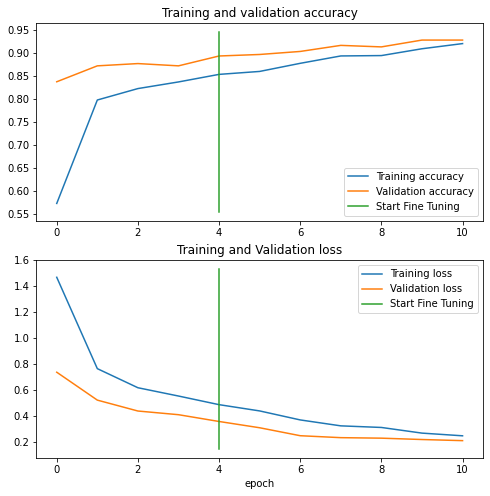

In [ ]:
compare_historys(history_2, history_3, 5)

## Model 4: Fine tuning existing model all of the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-03-04 16:48:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 173.194.198.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   139MB/s    in 3.6s    

2022-03-04 16:48:30 (137 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 12s 139ms/step - loss: 0.2083 - accuracy: 0.9292


[0.20831452310085297, 0.9291999936103821]

In [ ]:
#load model from checkpoint, to fine tune from the same stage the 10 percent data was fine tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.3709 - accuracy: 0.8928


[0.37089839577674866, 0.892799973487854]

In [ ]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 dense True


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        initial_epoch=history_2.epoch[-1],
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback('transfer_learning', 'full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220304-170025
Epoch 5/10
79/79 [==============================] - 27s 328ms/step - loss: 0.3560 - accuracy: 0.8816 - val_loss: 0.2655 - val_accuracy: 0.9178
Epoch 6/10
79/79 [==============================] - 29s 366ms/step - loss: 0.3326 - accuracy: 0.8968 - val_loss: 0.2681 - val_accuracy: 0.9145
Epoch 7/10
79/79 [==============================] - 25s 312ms/step - loss: 0.3146 - accuracy: 0.8960 - val_loss: 0.2224 - val_accuracy: 0.9375
Epoch 8/10
79/79 [==============================] - 24s 295ms/step - loss: 0.2791 - accuracy: 0.9044 - val_loss: 0.2022 - val_accuracy: 0.9375
Epoch 9/10
79/79 [==============================] - 24s 303ms/step - loss: 0.2486 - accuracy: 0.9192 - val_loss: 0.2040 - val_accuracy: 0.9391
Epoch 10/10
79/79 [==============================] - 24s 298ms/step - loss: 0.2278 - accuracy: 0.9232 - val_loss: 0.1819 - val_accuracy: 0.9490


5
11


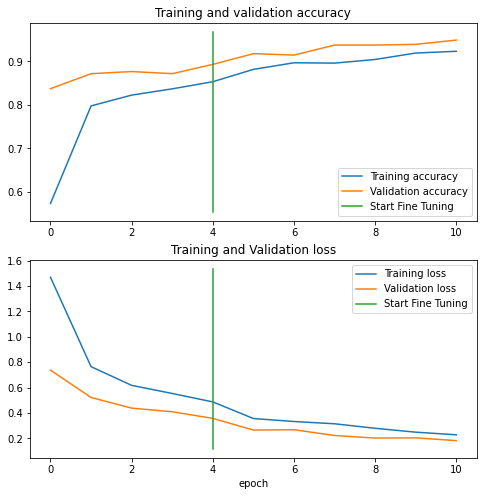

In [ ]:
compare_historys(history_2, history_4, 5)

In [ ]:
classes

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

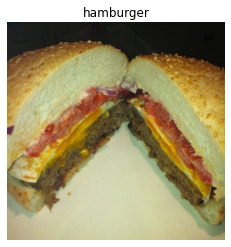

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(classes)
target_dir = '10_food_classes_all_data/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
image_path = target_dir + '/' + random_image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.title(target_class)
plt.axis(False);

In [ ]:
import numpy as np

img = tf.image.resize(img, [224, 224])

img.shape
pred = model_2.predict(tf.expand_dims(img, axis=0))

classes[np.argmax(pred)]

'hamburger'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")


input_shape = (224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

In [ ]:
checkpoint_path2 = "ten_percent_model_checkpoints_weights/checkpoint2.ckpt"

checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,
                                                         save_weights_only=True, 
                                                         save_best_only=False, 
                                                         save_freq="epoch", 
                                                         verbose=1)

In [ ]:
initial_epochs = 10
history_5 = model_3.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback('transfer_learning', '10_epochs'), checkpoint_callback2])

Saving TensorBoard log files to: transfer_learning/10_epochs/20220304-174533
Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 2.2526 - accuracy: 0.1796
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint2.ckpt
79/79 [==============================] - 30s 304ms/step - loss: 2.2526 - accuracy: 0.1796 - val_loss: 1.9886 - val_accuracy: 0.3684
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 1.9252 - accuracy: 0.3996
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint2.ckpt
79/79 [==============================] - 26s 320ms/step - loss: 1.9252 - accuracy: 0.3996 - val_loss: 1.6971 - val_accuracy: 0.6003
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 1.7011 - accuracy: 0.5484
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint2.ckpt
79/79 [==============================] - 23s 288ms/step - loss: 1.7011 - accuracy: 0.5484 - val_loss: 1.4817 - val_accuracy: 0.6743
Epoch

In [ ]:
model_3.evaluate(test_data)

79/79 [==============================] - 14s 162ms/step - loss: 0.7813 - accuracy: 0.8224


[0.7813003659248352, 0.8223999738693237]

In [ ]:
model_3.load_weights(checkpoint_path2)
model_3.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.7813 - accuracy: 0.8224


[0.7813007831573486, 0.8223999738693237]

In [ ]:
for layer in model_3.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
fine_tune_epochs = initial_epochs + 10

history_6 = model_3.fit(train_data_10_classes_full,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        initial_epoch=history_5.epoch[-1],
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks =[create_tensorboard_callback('transfer_learning', 'fine_tune_10_epochs_all_data')])

Saving TensorBoard log files to: transfer_learning/fine_tune_10_epochs_all_data/20220304-180243
Epoch 10/20
235/235 [==============================] - 69s 256ms/step - loss: 0.7302 - accuracy: 0.7652 - val_loss: 0.3991 - val_accuracy: 0.8684
Epoch 11/20
235/235 [==============================] - 56s 235ms/step - loss: 0.5606 - accuracy: 0.8156 - val_loss: 0.3325 - val_accuracy: 0.8947
Epoch 12/20
235/235 [==============================] - 57s 239ms/step - loss: 0.4837 - accuracy: 0.8417 - val_loss: 0.2898 - val_accuracy: 0.9062
Epoch 13/20
235/235 [==============================] - 52s 220ms/step - loss: 0.4307 - accuracy: 0.8612 - val_loss: 0.3279 - val_accuracy: 0.8931
Epoch 14/20
235/235 [==============================] - 52s 220ms/step - loss: 0.3841 - accuracy: 0.8776 - val_loss: 0.2933 - val_accuracy: 0.9030
Epoch 15/20
235/235 [==============================] - 53s 223ms/step - loss: 0.3429 - accuracy: 0.8869 - val_loss: 0.3102 - val_accuracy: 0.9112
Epoch 16/20
235/235 [=======

10
21


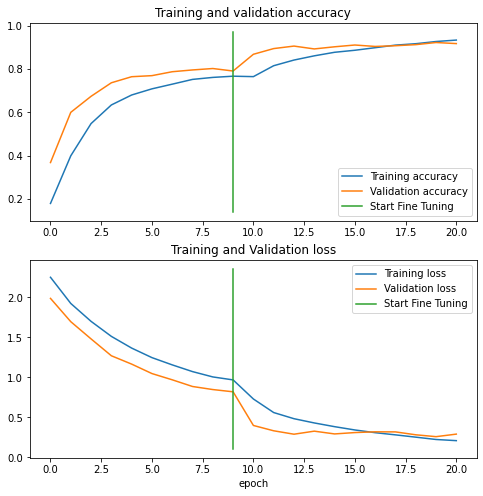

In [ ]:
compare_historys(history_5, history_6, 10)

overfitting??????

# Transfer Learning: Scaling up

In [ ]:
!nvidia-smi

Sun Mar  6 14:28:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-06 14:28:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-06 14:28:41 (113 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: workin with less data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-03-06 14:28:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   226MB/s    in 6.4s    

2022-03-06 14:28:53 (241 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/scallops'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/crab_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images 

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # for predictions analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        monitor='val_accuracy',
                                                        save_best_only=True)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


data_augmentation = Sequential([
                                preprocessing.RandomFlip('horizontal'),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2)
], name='data_augmentation')

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2d')(x)
outputs = layers.Dense(101, activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_0 = model.fit(train_data,
                      epochs=5,
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 89s 333ms/step - loss: 3.4704 - accuracy: 0.2477 - val_loss: 2.6645 - val_accuracy: 0.3742
Epoch 2/5
237/237 [==============================] - 63s 262ms/step - loss: 2.3512 - accuracy: 0.4601 - val_loss: 2.2200 - val_accuracy: 0.4586
Epoch 3/5
237/237 [==============================] - 58s 243ms/step - loss: 1.9791 - accuracy: 0.5341 - val_loss: 2.0906 - val_accuracy: 0.4694
Epoch 4/5
237/237 [==============================] - 58s 241ms/step - loss: 1.7499 - accuracy: 0.5820 - val_loss: 1.9660 - val_accuracy: 0.4887
Epoch 5/5
237/237 [==============================] - 52s 218ms/step - loss: 1.5960 - accuracy: 0.6051 - val_loss: 1.9447 - val_accuracy: 0.4889


In [ ]:
results_0 = model.evaluate(test_data)
results_0

790/790 [==============================] - 56s 71ms/step - loss: 1.7170 - accuracy: 0.5497


[1.7170255184173584, 0.549742579460144]

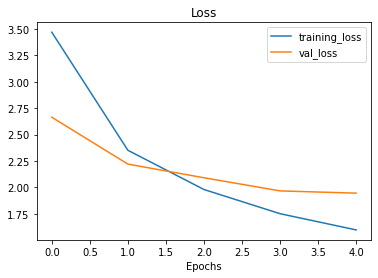

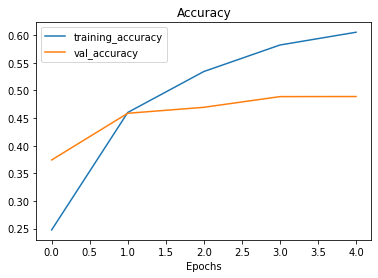

In [ ]:
plot_loss_curves(history_0)

### Fine-tuning

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

history_1 = model.fit(train_data,
                      epochs=10,
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[checkpoint_callback],
                      initial_epoch=history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 56s 210ms/step - loss: 1.3601 - accuracy: 0.6495 - val_loss: 1.8861 - val_accuracy: 0.5016
Epoch 6/10
237/237 [==============================] - 48s 200ms/step - loss: 1.2249 - accuracy: 0.6833 - val_loss: 1.8644 - val_accuracy: 0.5092
Epoch 7/10
237/237 [==============================] - 46s 192ms/step - loss: 1.1514 - accuracy: 0.6935 - val_loss: 1.8304 - val_accuracy: 0.5149
Epoch 8/10
237/237 [==============================] - 44s 186ms/step - loss: 1.0714 - accuracy: 0.7180 - val_loss: 1.8378 - val_accuracy: 0.5148
Epoch 9/10
237/237 [==============================] - 45s 189ms/step - loss: 1.0305 - accuracy: 0.7244 - val_loss: 1.8290 - val_accuracy: 0.5173
Epoch 10/10
237/237 [==============================] - 44s 183ms/step - loss: 0.9587 - accuracy: 0.7431 - val_loss: 1.8314 - val_accuracy: 0.5201


In [ ]:
results_1 = model.evaluate(test_data)
results_1

790/790 [==============================] - 57s 72ms/step - loss: 1.6205 - accuracy: 0.5726


[1.6204558610916138, 0.5725940465927124]

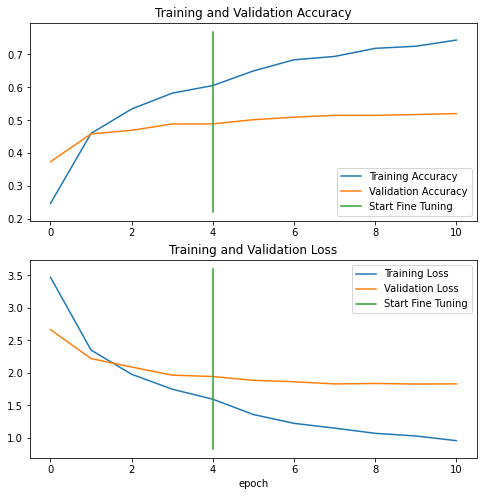

In [ ]:
compare_historys(history_0, history_1, 5)

In [ ]:
# model.save('drive/MyDrive/101_food_class_10_percent_model')

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 57s 72ms/step - loss: 1.6205 - accuracy: 0.5726


[1.6204558610916138, 0.5725940465927124]

In [ ]:
pred_probs = model.predict(test_data)

pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
pred_classes[:10], y_labels[:10]

(array([ 0,  0,  0,  8, 29, 78, 29, 46,  9,  0]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_labels, pred_classes)

0.5725940594059405

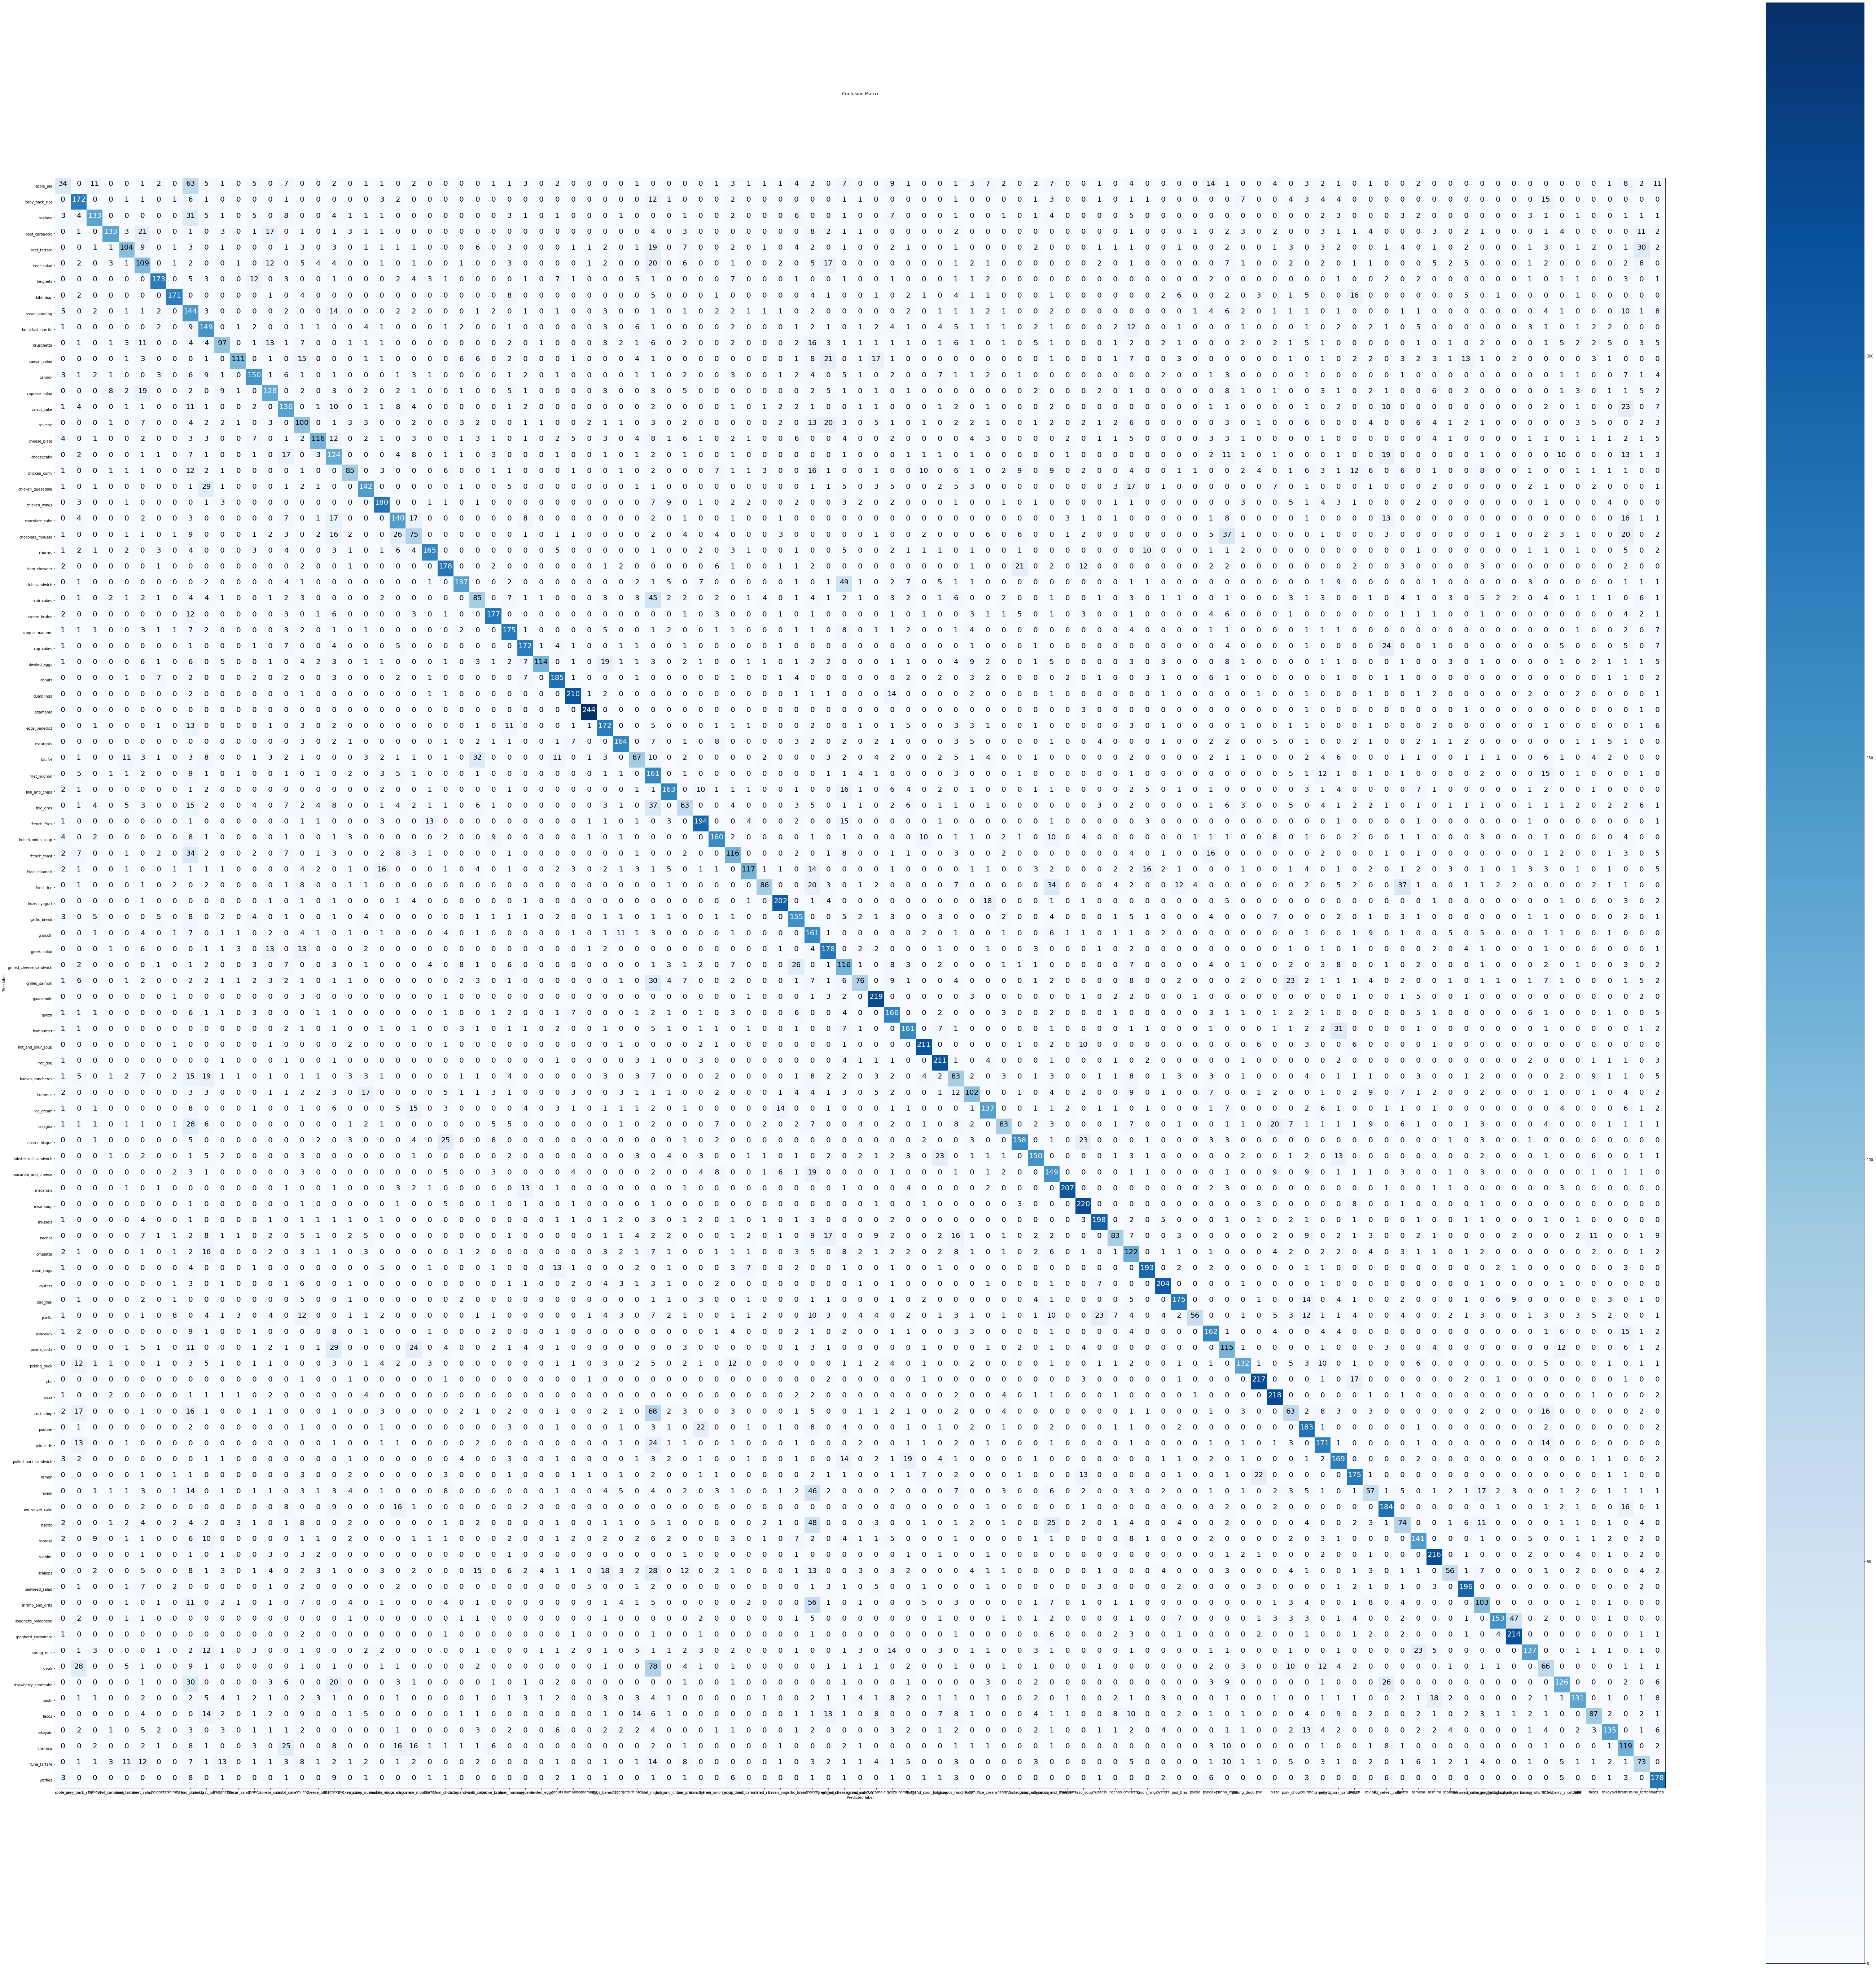

In [ ]:
from helper_functions import make_confusion_matrix

class_names = test_data.class_names

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.32      0.14      0.19       250
           1       0.54      0.69      0.60       250
           2       0.70      0.53      0.60       250
           3       0.81      0.53      0.64       250
           4       0.60      0.42      0.49       250
           5       0.36      0.44      0.39       250
           6       0.80      0.69      0.74       250
           7       0.83      0.68      0.75       250
           8       0.20      0.58      0.30       250
           9       0.40      0.60      0.48       250
          10       0.56      0.39      0.46       250
          11       0.84      0.44      0.58       250
          12       0.65      0.60      0.62       250
          13       0.54      0.51      0.52       250
          14       0.45      0.54      0.49       250
          15       0.33      0.40      0.36       250
          16       0.71      0.46      0.56       250
          17       0.34    

In [ ]:
class_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

class_f1_scores = {}
for k, v in class_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]]=v['f1-score']

class_f1_scores

{'apple_pie': 0.1915492957746479,
 'baby_back_ribs': 0.6045694200351495,
 'baklava': 0.6045454545454546,
 'beef_carpaccio': 0.6425120772946861,
 'beef_tartare': 0.491725768321513,
 'beet_salad': 0.3920863309352518,
 'beignets': 0.7424892703862661,
 'bibimbap': 0.7516483516483516,
 'bread_pudding': 0.30157068062827225,
 'breakfast_burrito': 0.4806451612903226,
 'bruschetta': 0.45754716981132076,
 'caesar_salad': 0.581151832460733,
 'cannoli': 0.6224066390041493,
 'caprese_salad': 0.5235173824130879,
 'carrot_cake': 0.49454545454545457,
 'ceviche': 0.3629764065335753,
 'cheese_plate': 0.5617433414043583,
 'cheesecake': 0.4025974025974026,
 'chicken_curry': 0.4347826086956522,
 'chicken_quesadilla': 0.604255319148936,
 'chicken_wings': 0.7086614173228346,
 'chocolate_cake': 0.5353728489483747,
 'chocolate_mousse': 0.32537960954446854,
 'churros': 0.7300884955752213,
 'clam_chowder': 0.6819923371647508,
 'club_sandwich': 0.6342592592592593,
 'crab_cakes': 0.37946428571428564,
 'creme_brule

In [ ]:
import pandas as pd

f1_scores = pd.DataFrame({'class_name': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
                        
f1_scores

class_name  f1-score
33            edamame  0.953125
63           macarons  0.878981
75                pho  0.836224
32          dumplings  0.817121
54  hot_and_sour_soup  0.813102
..                ...       ...
39          foie_gras  0.300000
77          pork_chop  0.290993
93              steak  0.287582
82            ravioli  0.279412
0           apple_pie  0.191549

[101 rows x 2 columns]

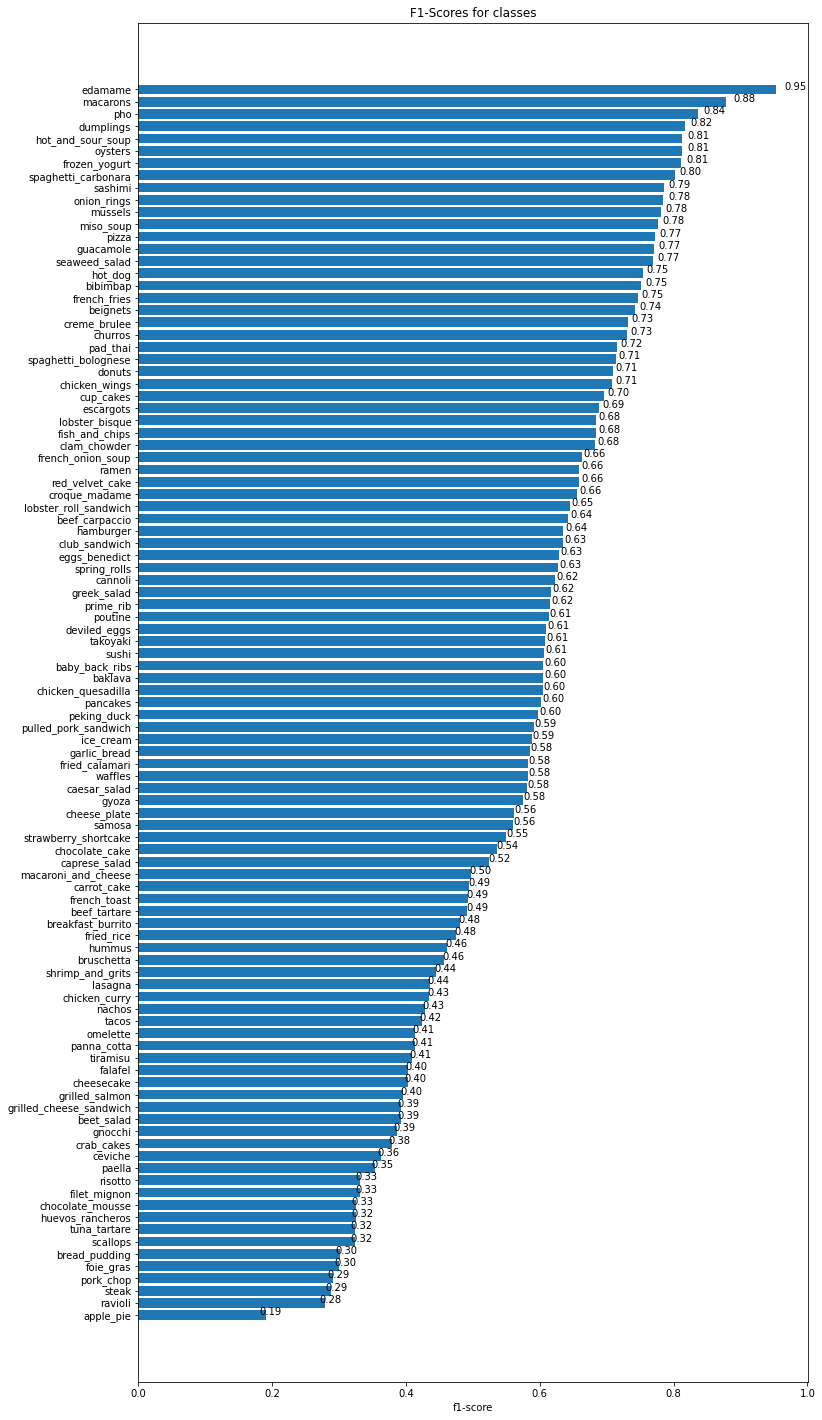

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores['class_name']))
ax.set_xlabel('f1-score')
ax.set_title('F1-Scores for classes')
ax.invert_yaxis();

def autolabel(rects):
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f'{width:.2f}',
            ha='center', va='bottom')
    
autolabel(scores)

In [ ]:
def load_and_prep_img(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)

  img = tf.io.decode_image(img)

  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

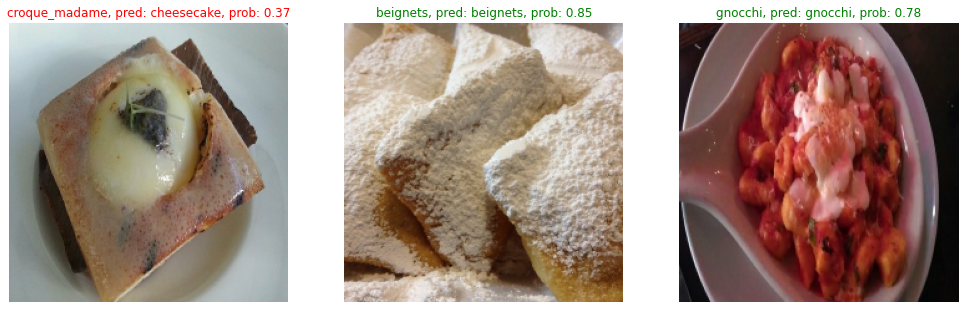

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))

for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename

  img = load_and_prep_img(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]


  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'

  plt.title(f'{class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}', c=title_color)
  plt.axis(False);

In [ ]:
filepaths = []
for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg', shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd

pred_df = pd.DataFrame({'img_path' : filepaths,
                        'y_true' : y_labels,
                        'y_pred' : pred_classes,
                        'pred_conf' : pred_probs.max(axis=1),
                        'y_true_classname' : [class_names[i] for i in y_labels],
                        'y_pred_classname' : [class_names[i] for i in pred_classes]})

pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   

   pred_conf y_true_classname y_pred_classname  
0   0.224917        apple_pie        apple_pie  
1   0.884656        apple_pie        apple_pie  
2   0.267476        apple_pie        apple_pie  
3   0.248945        apple_pie    bread_pudding  
4   0.279632        apple_pie        cup_cakes

In [ ]:
pred_df['pred_correct'] = pred_df['y_true_classname'] == pred_df['y_pred_classname']

pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      29   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.224917        apple_pie        apple_pie          True  
1   0.884656        apple_pie        apple_pie          True  
2   0.267476        apple_pie        apple_pie          True  
3   0.248945        apple_pie    bread_pudding         False  
4   0.279632        apple_pie        cup_cakes         False

In [ ]:
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head(10)

img_path  y_true  y_pred  \
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
11041  b'101_food_classes_10_percent/test/fried_rice/...      44      51   
22203  b'101_food_classes_10_percent/test/seaweed_sal...      88      51   
22511  b'101_food_classes_10_percent/test/spaghetti_b...      90      78   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
19521  b'101_food_classes_10_percent/test/poutine/132...      78      40   
23935  b'101_food_classes_10_percent/test/sushi/46797...      95      86   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   

       pred_conf      y_true_classname y_pred_classname  pred_correct  
23797   0.999525                 sushi          sashimi         False  
23631   0.998890  strawberry_shortcake  red_velvet_cake         False  
18001   0.998488              pancakes         omelette         False  
11041   0.994619            fried_rice        guacamole         False  
22203   0.994496         seaweed_salad        guacamole         False  
22511   0.994399   spaghetti_bolognese          poutine         False  
10847   0.994313        fried_calamari      onion_rings         False  
19521   0.994132               poutine     french_fries         False  
23935   0.993236                 sushi          sashimi         False  
5849    0.993191               churros      onion_rings         False

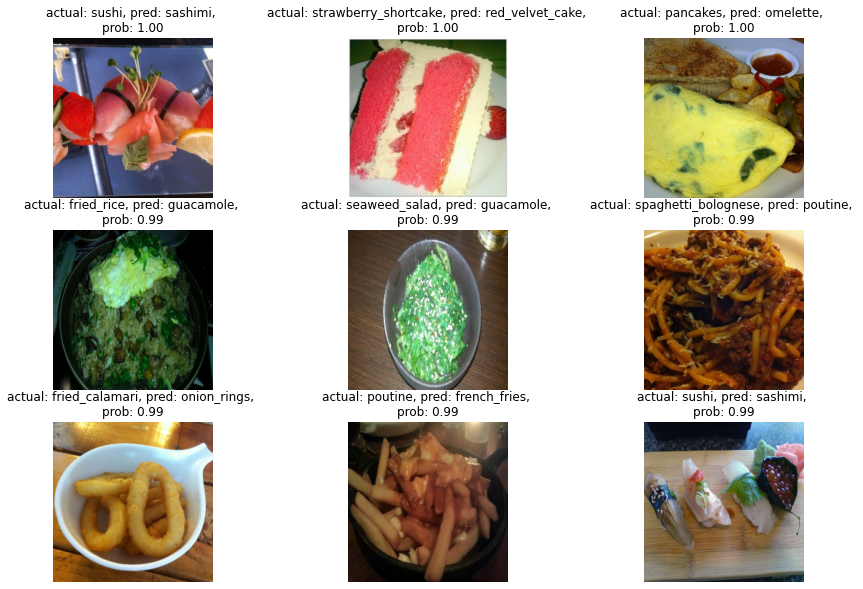

In [ ]:
images_to_view = 9

start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_img(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row
  plt.imshow(img)
  plt.title(f'actual: {y_true}, pred: {y_pred}, \nprob: {pred_prob:.2f}')
  plt.axis(False)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2022-03-06 15:48:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.08s   

2022-03-06 15:48:55 (151 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg']

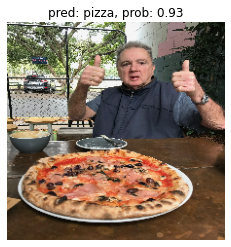

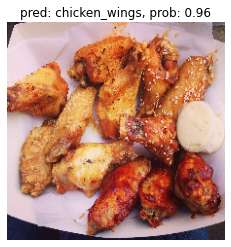

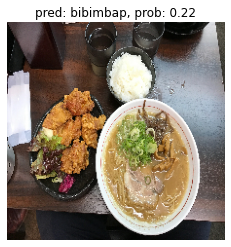

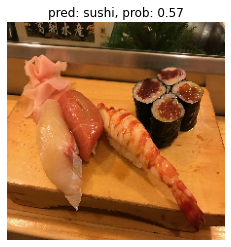

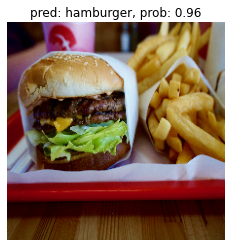

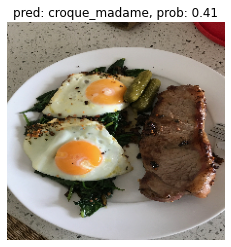

In [ ]:
for img in custom_food_images:
  img = load_and_prep_img(img, scale=False) 
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
  pred_class = class_names[pred_prob.argmax()] 
  plt.figure()
  plt.imshow(img/255.) 
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)